In [1]:
print('셀 실행은 shift + enter')

셀 실행은 shift + enter


In [2]:
import sys
print(sys.version)

3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:53:08) 
[Clang 15.0.7 ]


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.15.0


In [56]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [57]:
print(train_images.shape, test_images.shape)

집합, 도수 = np.unique(train_labels, return_counts=True)
print(f'labels={집합}, 도수={도수}')
pd.Series(train_labels).value_counts().sort_index()

(60000, 28, 28) (10000, 28, 28)
labels=[0 1 2 3 4 5 6 7 8 9], 도수=[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

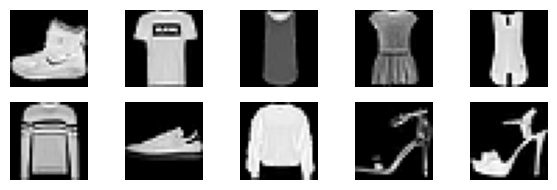

In [58]:
그림틀, 영역 = plt.subplots(2, 5, figsize=(6, 2))
for 그래프, 이미지 in zip(영역.flat, train_images):
    그래프.imshow(이미지, cmap='gray')
    그래프.axis('off')
    
plt.tight_layout()    
plt.show()


In [66]:
def 전처리(images, 목표형상):
    images = images.reshape(-1, *목표형상)
    images = images.astype('float32')
    images /= 255
    return images

목표형상 = (784,)
X_train = 전처리(train_images, 목표형상)
X_test = 전처리(test_images, 목표형상)
assert  목표형상 == X_train.shape[1:] == X_test.shape[1:]
assert 'float32' == X_train.dtype == X_test.dtype
assert np.isclose(0, X_train.min()) and np.isclose(1, X_train.max())
assert np.isclose(0, X_test.min()) and np.isclose(1, X_test.max())
print(train_images.shape, '->', X_train.shape)
print(train_images.dtype, '->', X_train.dtype)
print(f'{train_images.min()} <= pixel <= {train_images.max()}')
print(f'{X_train.min()} <= pixel <= {X_train.max()}')

(60000, 28, 28) -> (60000, 784)
uint8 -> float32
0 <= pixel <= 255
0.0 <= pixel <= 1.0


훈련/검증/시험

In [107]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, train_labels, test_size=0.2, shuffle=True)

print(f'{len(train_images)} = {len(X_train)} + {len(X_val)}')

60000 = 48000 + 12000


In [112]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.losses as losses

with tf.device('cpu'):
    model = keras.Sequential([
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='rmsprop', 
        loss=losses.sparse_categorical_crossentropy,
        metrics=['accuracy'])
    
    results = model.fit(
        X_train, y_train, epochs=10, batch_size=100, 
        validation_data=(X_val, y_val), 
        callbacks=[
            keras.callbacks.ModelCheckpoint(
                filepath='fashion_model.keras', save_best_only=True),
        ]
    )

Epoch 1/10
480/480 [==============================] - 2s 4ms/step - loss: 0.5638 - accuracy: 0.8017 - val_loss: 0.4168 - val_accuracy: 0.8510
Epoch 2/10
480/480 [==============================] - 2s 4ms/step - loss: 0.3903 - accuracy: 0.8573 - val_loss: 0.3759 - val_accuracy: 0.8637
Epoch 3/10
480/480 [==============================] - 2s 3ms/step - loss: 0.3459 - accuracy: 0.8733 - val_loss: 0.3323 - val_accuracy: 0.8753
Epoch 4/10
480/480 [==============================] - 2s 3ms/step - loss: 0.3172 - accuracy: 0.8828 - val_loss: 0.3327 - val_accuracy: 0.8818
Epoch 5/10
480/480 [==============================] - 2s 3ms/step - loss: 0.2998 - accuracy: 0.8890 - val_loss: 0.3250 - val_accuracy: 0.8798
Epoch 6/10
480/480 [==============================] - 2s 3ms/step - loss: 0.2831 - accuracy: 0.8942 - val_loss: 0.3140 - val_accuracy: 0.8887
Epoch 7/10
480/480 [==============================] - 2s 3ms/step - loss: 0.2716 - accuracy: 0.9011 - val_loss: 0.3242 - val_accuracy: 0.8838
Epoch 

Best Vs. Last Epoch

In [117]:
with tf.device('cpu'):
    print('Last epoch model')
    val_loss, val_acc = model.evaluate(X_val, y_val)
    print(f'val_loss={val_loss:.4f}, val_acc={val_acc:.4f}')
    # best epoch
    # 최고 성능의 모델을 불러온다.
    print('Best epoch model')
    model.load_weights('fashion_model.keras')
    val_loss, val_acc = model.evaluate(X_val, y_val)
    print(f'val_loss={val_loss:.4f}, val_acc={val_acc:.4f}')

Last epoch model
375/375 [==============================] - 0s 799us/step - loss: 0.3238 - accuracy: 0.8929
val_loss=0.3238, val_acc=0.8929
Best epoch model
375/375 [==============================] - 0s 748us/step - loss: 0.3140 - accuracy: 0.8887
val_loss=0.3140, val_acc=0.8887


In [118]:
훈련결과표 = pd.DataFrame(results.history)
훈련결과표.round(3)[-3:]

,loss,accuracy,val_loss,val_accuracy
7,0.260,0.904,0.315,0.891
8,0.251,0.907,0.315,0.890
9,0.240,0.911,0.324,0.893


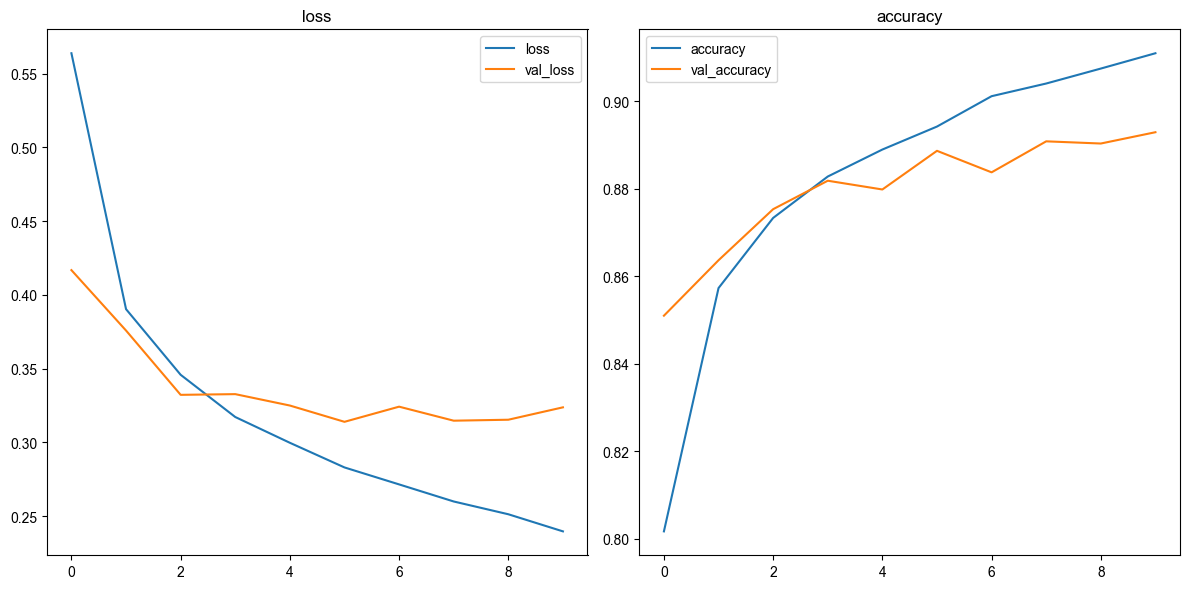

In [119]:
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 2, 1)
훈련결과표[['loss', 'val_loss']].plot(title='loss', ax=ax)
ax = plt.subplot(1, 2, 2)
훈련결과표[['accuracy', 'val_accuracy']].plot(title='accuracy', ax=ax)
plt.tight_layout()
plt.show()

In [120]:
X_test = 전처리(test_images, 목표형상)
with tf.device('cpu'):
    outputs = model.predict(X_test)
print(X_test.shape, '-> model ->', outputs.shape)

예측 = np.argmax(outputs, axis=1)
print(예측[:5], '?=', test_labels[:5])

313/313 [==============================] - 0s 638us/step
(10000, 784) -> model -> (10000, 10)
[9 2 1 1 6] ?= [9 2 1 1 6]


In [89]:
열제목 = [f'Pr(y={i}|x)' for i in range(10)]
pd.DataFrame(outputs, columns=열제목).round(2)[:10]

,Pr(y=0|x),Pr(y=1|x),Pr(y=2|x),Pr(y=3|x),Pr(y=4|x),Pr(y=5|x),Pr(y=6|x),Pr(y=7|x),Pr(y=8|x),Pr(y=9|x)
0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0
1,0.00,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,0.00,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,0.00,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,0.82,0.0,0.0,0.0,0.0,0.0,0.18,0.0,0.0,0.0
5,0.00,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
6,0.00,0.0,0.0,0.0,1.0,0.0,0.00,0.0,0.0,0.0
7,0.00,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.0
8,0.00,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0
9,0.00,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0


목표: 오답들을 선별 해내고 오답에 대한 예측 자신감을 분석해 보기

In [91]:
예측 = np.argmax(outputs, axis=1)
오답필터 = 예측 != test_labels  # True: 오답
print(f'오답 개수: {오답필터.sum()} / {len(test_labels)}')
pd.DataFrame(outputs, columns=열제목).round(2)[오답필터][:10]

오답 개수: 1066 / 10000


,Pr(y=0|x),Pr(y=1|x),Pr(y=2|x),Pr(y=3|x),Pr(y=4|x),Pr(y=5|x),Pr(y=6|x),Pr(y=7|x),Pr(y=8|x),Pr(y=9|x)
4,0.82,0.0,0.00,0.00,0.00,0.0,0.18,0.0,0.0,0.0
12,0.00,0.0,0.00,0.00,0.00,1.0,0.00,0.0,0.0,0.0
17,0.00,0.0,0.99,0.00,0.01,0.0,0.00,0.0,0.0,0.0
23,0.00,0.0,0.00,0.00,0.00,1.0,0.00,0.0,0.0,0.0
29,0.55,0.0,0.00,0.07,0.01,0.0,0.37,0.0,0.0,0.0
40,1.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0
42,0.11,0.0,0.00,0.00,0.00,0.0,0.89,0.0,0.0,0.0
43,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.2,0.0,0.8
49,0.00,0.0,0.01,0.00,0.01,0.0,0.98,0.0,0.0,0.0
51,0.00,0.0,0.93,0.00,0.07,0.0,0.00,0.0,0.0,0.0


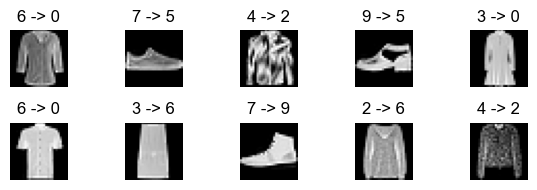

In [92]:
그림틀, 영역 = plt.subplots(2, 5, figsize=(6, 2))
for 그래프, 이미지, 라벨, 예측 in zip(
    영역.flat, test_images[오답필터], test_labels[오답필터], 예측[오답필터]):
    그래프.imshow(이미지, cmap='gray')
    그래프.set_title(f'{라벨} -> {예측}')
    그래프.axis('off')
    
plt.tight_layout()
plt.show()

목표: 유형별 이미지 샘플들을 열 개씩 출력 해 보기

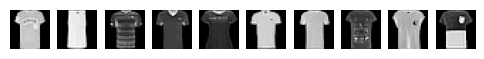

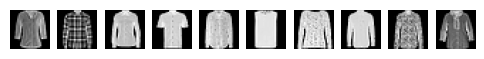

In [100]:
def 라벨별이미지출력(라벨, images, labels, n=10):
    라벨필터 = labels == 라벨
    그림틀, 영역 = plt.subplots(1, 10, figsize=(6, 2))
    for 그래프, 이미지 in zip(영역.flat, images[라벨필터][:n]):
        그래프.imshow(이미지, cmap='gray')
        그래프.axis('off')    
    plt.show()

라벨별이미지출력(0, test_images, test_labels)
라벨별이미지출력(6, test_images, test_labels)

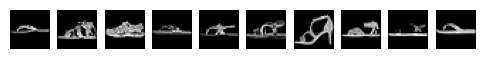

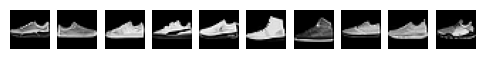

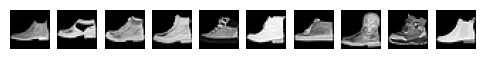

In [101]:
라벨별이미지출력(5, test_images, test_labels)
라벨별이미지출력(7, test_images, test_labels)
라벨별이미지출력(9, test_images, test_labels)

In [121]:
# 예측 = np.argmax(outputs, axis=1)
# print(예측[:5], '...')
# 채점 = 예측 == test_labels
# print(f'정확도={채점.mean():.2%}')
with tf.device('cpu'):
    손실, 정확도 = model.evaluate(X_test, test_labels, batch_size=200)
print(f'손실={손실:.4f}, 정확도={정확도:.2%}')
열제목 = [f'Pr(y={i}|x)' for i in range(10)]
pd.DataFrame(outputs, columns=열제목).round(3).head()

50/50 [==============================] - 0s 1ms/step - loss: 0.3538 - accuracy: 0.8803
손실=0.3538, 정확도=88.03%


,Pr(y=0|x),Pr(y=1|x),Pr(y=2|x),Pr(y=3|x),Pr(y=4|x),Pr(y=5|x),Pr(y=6|x),Pr(y=7|x),Pr(y=8|x),Pr(y=9|x)
0,0.000,0.0,0.000,0.000,0.000,0.089,0.000,0.054,0.0,0.857
1,0.000,0.0,0.999,0.000,0.000,0.000,0.000,0.000,0.0,0.000
2,0.000,1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000
3,0.000,1.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000
4,0.201,0.0,0.014,0.001,0.001,0.000,0.783,0.000,0.0,0.000


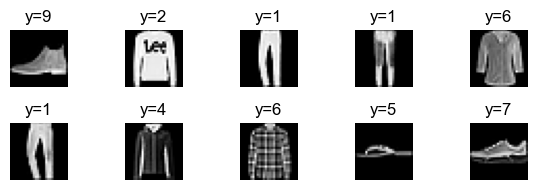

In [63]:
그림틀, 영역 = plt.subplots(2, 5, figsize=(6, 2))
for 그래프, 이미지, 라벨 in zip(영역.flat, test_images, test_labels):
    그래프.imshow(이미지, cmap='gray')
    그래프.set_title(f'y={라벨}')
    그래프.axis('off')

plt.tight_layout()
plt.show()